#### Franka Cabinet Notebook

Imports first

In [2]:
import matplotlib.pyplot as plt
import gym
from IPython import display
import numpy as np
import onnx
import onnxruntime as ort
import pandas as pd
import shap


shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Load the ONNX model

Franka Environment has 23 float observations, and has 9 float action space

In [20]:
ort_model = ort.InferenceSession("resources/FRANKA_CAB_MINUS_5/frankacab_without5.onnx")

outputs = ort_model.run(
    None,
    {"obs": np.zeros((1, 23)).astype(np.float32)},
)


features_name_panda = ['dof1','dof2','dof3','dof4','dof5','dof6','dof7','grip1','grip2','missing1','missing2','missing3','missing4','missing5','dist_to_handleX','dist_to_handleY','dist_to_handleZ','cabX','cabY','cabZ','cabLVX','cabLVY','cabLVZ']

print(outputs)

[array([[-0.2778707 ,  0.90878344, -3.2206986 , -1.5317274 , -2.1093001 ,
        -1.5647595 ,  0.56910264,  0.3517421 , -1.3691432 ]],
      dtype=float32), array([[-1.3879079 , -0.27793673, -1.0140573 , -0.8588334 , -0.36945552,
        -0.6735464 , -1.3035738 , -0.6433378 , -0.37926856]],
      dtype=float32), array([[-1.8678527]], dtype=float32)]


We need to create a method that wraps this onnx return

In [4]:
def predict_model(observation):    
   
    outputs = ort_model.run(None, {"obs": np.expand_dims(observation, axis=0).astype(np.float32)},)
    mu = outputs[0].squeeze(0)
    #print(mu)
    #sigma = np.exp(outputs[1].squeeze(0))
    #print(sigma)
    #action = np.random.normal(mu, sigma)
    out_action = np.clip(mu, a_min = -1.0, a_max = 1.0) 
    
    return out_action

In [5]:
def predict_all(observations):
    ret = []
    for x in observations:
        ret.append(predict_model(x))
    ret = np.array(ret)

    return ret

Load in Training Data

In [8]:
training = 'resources/FRANKA_CAB_MINUS_5/all_df-minus5.csv'
test = 'resources/FRANKA_CAB_MINUS_5/single_episode-minus5.csv'

all = pd.read_csv(training)
single =  pd.read_csv(test)

all['X'] = [eval(x) for x in all['X']]
all['Y'] = [eval(x) for x in all['Y']]
single['X'] = [eval(x) for x in single['X']]
single['Y'] = [eval(x) for x in single['Y']]




print(all.loc[0].X)
print("----")
print(predict_model(all.loc[0].X))
print("----")
print(all.loc[0].Y)

xTrain_np = np.array(all['X'].tolist())
xTest_np =  np.array(single['X'].tolist())


[0.0, 0.0, -0.06745660305023193, -0.4525439143180847, -0.6301239728927612, -0.46330326795578003, 0.14295804500579834, 1.0, 0.9080578088760376, 0.020199408754706383, 0.0, -0.013865135610103607, -0.030366454273462296, -0.004304330330342054, 0.0, -0.011897183023393154, -3.3226577215828e-05, 0.0, -0.40766286849975586, -0.06565835326910019, -0.08816230297088623, 4.122211461066172e-09, -7.30780982394208e-08]
----
[ 1.          1.         -1.          1.          1.          0.54761994
 -1.         -0.9587031   0.89141136]
----
[1.0, 1.0, -1.0, 1.0, 1.0, 0.5476193428039551, -1.0, -0.9587030410766602, 0.891410768032074]


In [22]:
# Cut off the bottom 300 rows
all_cut = pd.read_csv(training).iloc[:-300]
single_cut =  pd.read_csv(test).iloc[:-300]

print(all_cut)
print(single_cut)

all_cut['X'] = [eval(x) for x in all_cut['X']]
all_cut['Y'] = [eval(x) for x in all_cut['Y']]
single_cut['X'] = [eval(x) for x in single_cut['X']]
single_cut['Y'] = [eval(x) for x in single_cut['Y']]

cut_xTrain_np = np.array(all_cut['X'].tolist())
cut_xTest_np =  np.array(single_cut['X'].tolist())

explainer = shap.KernelExplainer(predict_all, shap.sample(cut_xTrain_np, 50))

shap_values = explainer.shap_values(cut_xTest_np)
print("shap_values =", shap_values)
print("base value =", explainer.expected_value)

df_cut = pd.DataFrame({"shap_values": shap_values,"base_value":  explainer.expected_value})


df_cut.to_pickle("resources/FRANKA_CAB/shap_values_franka_cab_cut.pkl")

      Unnamed: 0                                                  X  \
0              0  [0.0, 0.0, -0.06745660305023193, -0.4525439143...   
1              1  [0.0, 0.0, -0.06876283884048462, -0.4524552822...   
2              2  [0.0, 0.0, -0.0716065764427185, -0.44876754283...   
3              3  [0.0, 0.0, -0.0760921835899353, -0.44139432907...   
4              4  [0.0, 0.0, -0.08210396766662598, -0.4313559532...   
...          ...                                                ...   
4674        4674  [0.0, 0.0, -0.1499229073524475, -0.77396380901...   
4675        4675  [0.0, 0.0, -0.1489924192428589, -0.77427160739...   
4676        4676  [0.0, 0.0, -0.14826011657714844, -0.7746922373...   
4677        4677  [0.0, 0.0, -0.14766693115234375, -0.7752563953...   
4678        4678  [0.0, 0.0, -0.14686477184295654, -0.7754689455...   

                                                      Y  
0     [1.0, 1.0, -1.0, 1.0, 1.0, 0.5476193428039551,...  
1     [1.0, 1.0, -1.0, 1.0, 0.7

  0%|          | 0/199 [00:00<?, ?it/s]

shap_values = [array([[ 0.        ,  0.        , -0.28210383, ...,  0.06217158,
        -0.18416169,  0.15440368],
       [ 0.        ,  0.        , -0.29409928, ...,  0.06801653,
        -0.19757682,  0.15487698],
       [ 0.        ,  0.        , -0.26256849, ...,  0.1122065 ,
        -0.23837785,  0.15227705],
       ...,
       [ 0.        ,  0.        , -0.14747743, ..., -0.01943039,
         0.12008682, -0.06245967],
       [ 0.        ,  0.        , -0.14238454, ..., -0.01871872,
         0.11985188, -0.05741756],
       [ 0.        ,  0.        , -0.15143579, ..., -0.01716163,
         0.11623625, -0.06503952]]), array([[ 0.        ,  0.        ,  0.13742689, ..., -0.23745821,
         0.51324704,  0.14976131],
       [ 0.        ,  0.        ,  0.09219828, ..., -0.32697482,
         0.36929384,  0.15151952],
       [ 0.        ,  0.        ,  0.0702203 , ..., -0.32742199,
         0.28920305,  0.1537704 ],
       ...,
       [ 0.        ,  0.        , -0.04792507, ...,  0.0438

In [11]:
explainer = shap.KernelExplainer(predict_all, shap.sample(xTrain_np, 50))

shap_values = explainer.shap_values(xTest_np)
print("shap_values =", shap_values)
print("base value =", explainer.expected_value)

df = pd.DataFrame({"shap_values": shap_values,"base_value":  explainer.expected_value})
df.to_pkl("resources/FRANKA_CAB_MINUS_5/shap_values_franka_cab.pkl")

  0%|          | 0/499 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
df.to_pickle("resources/FRANKA_CAB_MINUS_5/shap_values_franka_cab.pkl")

df = pd.read_pickle("resources/FRANKA_CAB_MINUS_5/shap_values_franka_cab.pkl")

explainer = shap.KernelExplainer(predict_all, shap.sample(xTrain_np, 50))

shap_values = df['shap_values'].to_list()
explainer.expected_values = df['base_value'].to_list()


In [ ]:
# Action Plot






199
[ 0.          0.         -0.28210383 -0.12242492  0.26917683 -0.17942625
  0.24145973  0.          0.00812237  0.14988697  0.          0.02329241
 -0.02052206  0.02913158  0.         -0.01053752 -0.0058265   0.
  0.78605623  0.09506025  0.06217158 -0.18416169  0.15440368]


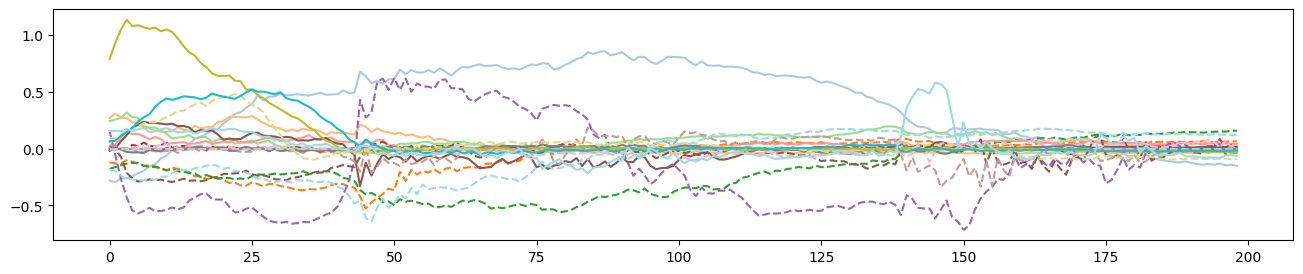

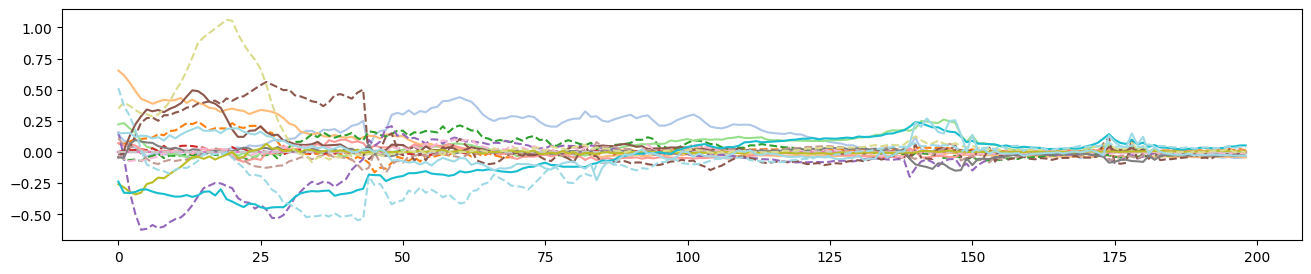

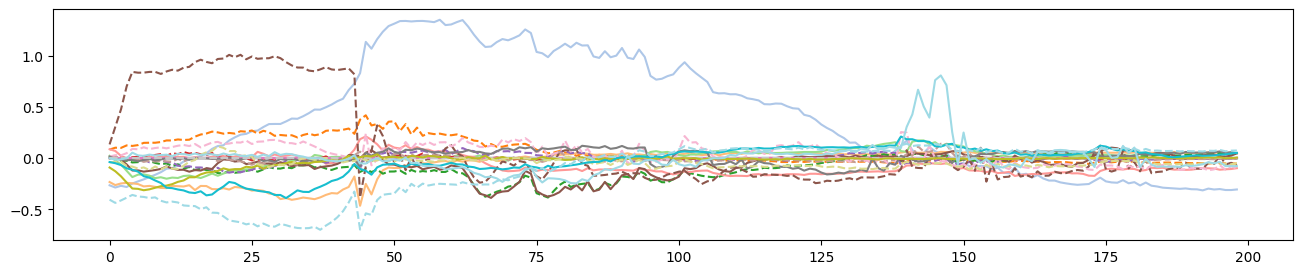

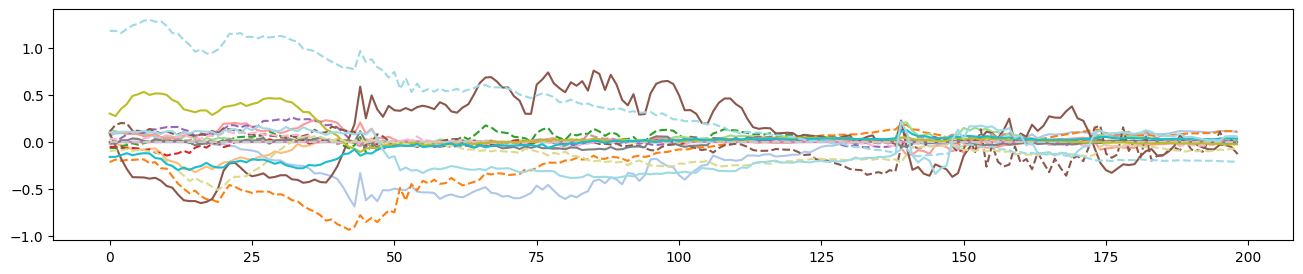

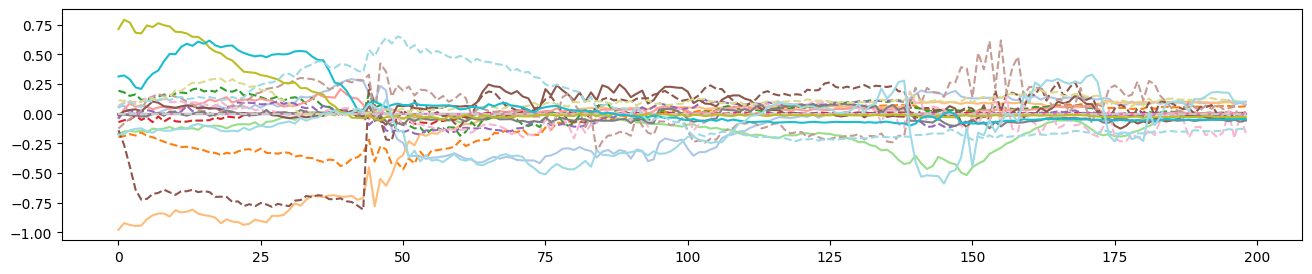

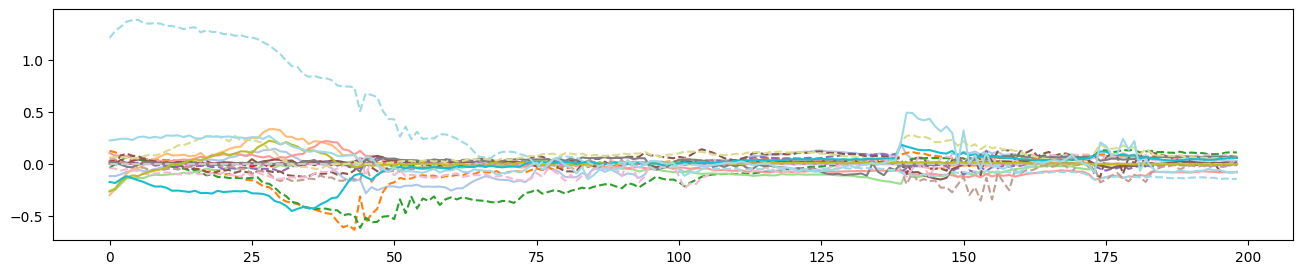

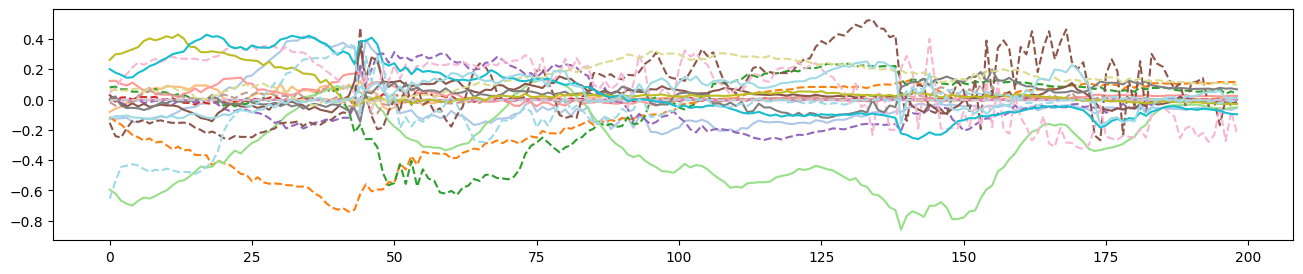

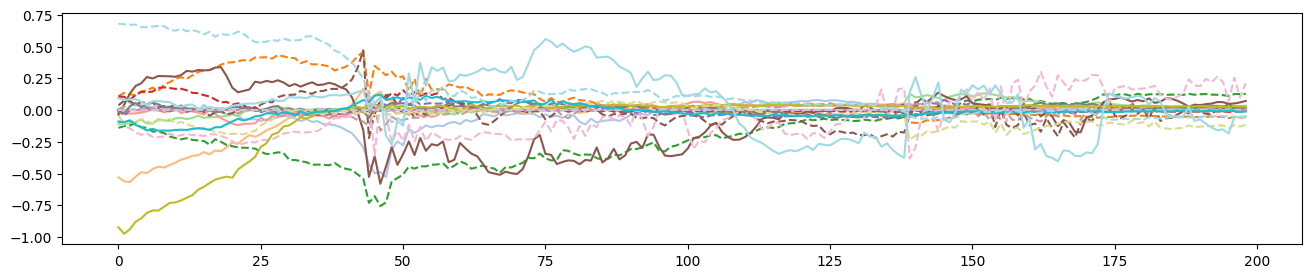

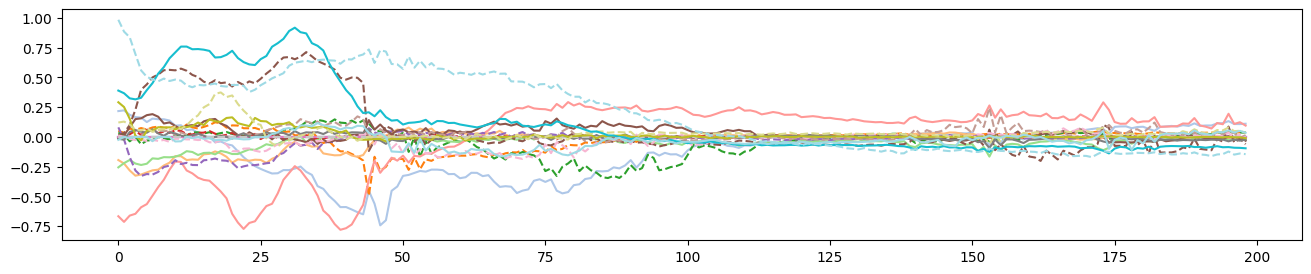

In [24]:
# Choose a colormap
cmap = plt.colormaps.get_cmap('tab20')
# Generate a linear space of colors
line_colors = cmap(np.linspace(0, 1, 23))

print(len(shap_values[0][:,0]))
print(shap_values[0][0])


for i in range(len(shap_values)):        

    # Set the size of the plot
    fig, ax = plt.subplots(figsize=(16, 3))  # Adjust the width and height as needed

    
    # Plot each line with the specified color
    for j in range(len(shap_values[0][0])):

        if j % 2 == 0:
            linestyle = 'solid'  # Make every even line solid
        else:
            linestyle = 'dashed'  # Make every odd line dashed
            
        plt.plot(shap_values[i][:,j], color=line_colors[j],linestyle=linestyle)

    #plt.legend(features_name_panda, loc='lower right')
    plt.show()

In [25]:
shap.initjs()

shap.force_plot(explainer.expected_value[0], shap_values[0], cut_xTest_np, feature_names=features_name_panda)

#for i in range(9):
    #shap.force_plot(explainer.expected_value[i], shap_values[i], xTest_np, matplotlib=True)

9
498


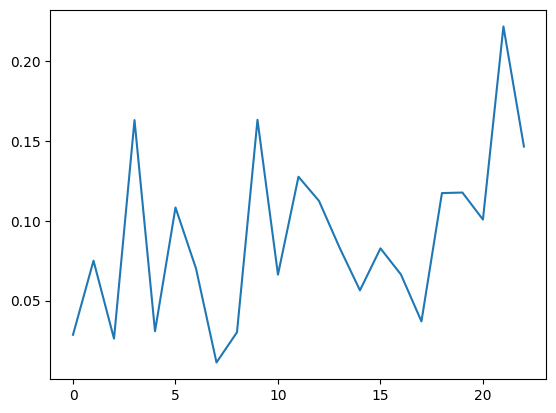

In [9]:
# shap_values return in -> Y return, Episode Number, Obersvation Weight
print(len(shap_values))
print(len(shap_values[0]))

obs_weights = []

for action_index in range(len(shap_values)):
    
    #for episode_index in range(len(shap_values[0])):
    for episode_index in range(0,150):
        
        for value in range(len(shap_values[0][0])):
            if len(obs_weights) != 23:
                obs_weights.append([])
            
            obs_weights[value].append(abs(shap_values[action_index][episode_index][value]))
    
obs_average = []

for observation_list in range(len(obs_weights)):
    obs_average.append([])

    obs_average[observation_list] = sum(obs_weights[observation_list]) / len(obs_weights[observation_list])


plt.plot(obs_average)
plt.show()

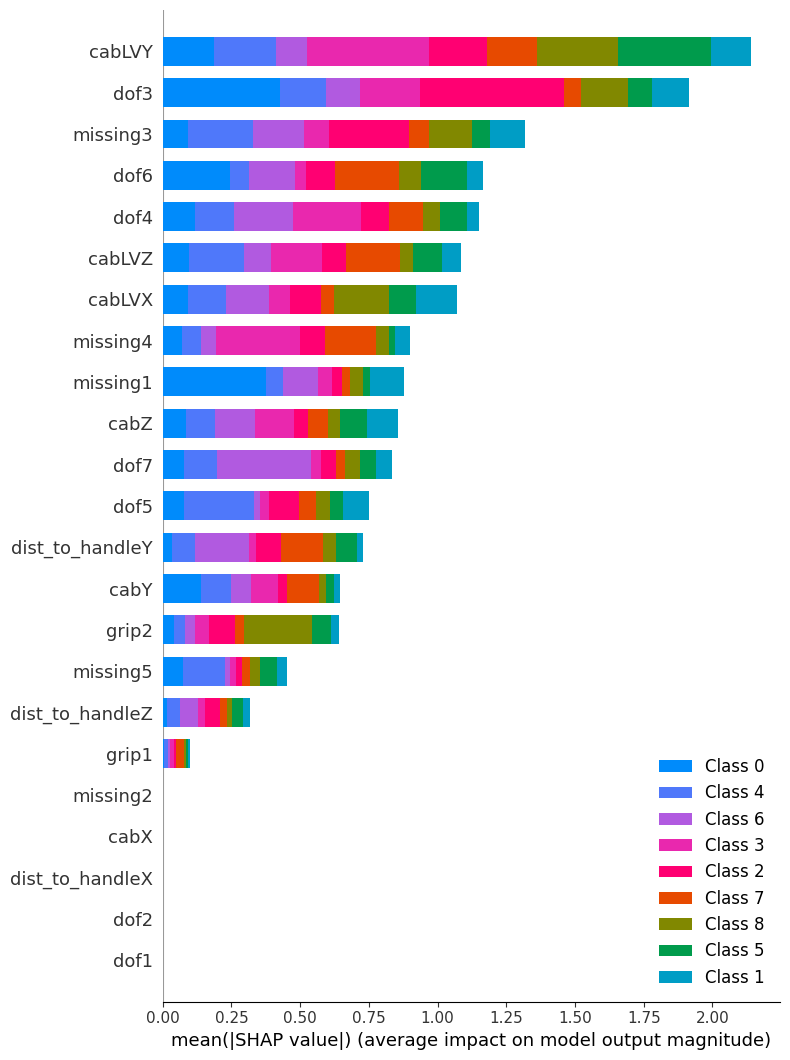

In [23]:
shap.summary_plot(shap_values,cut_xTest_np, plot_type='bar', feature_names=features_name_panda,max_display=23 )

In [26]:
print(sum(shap_values[0][0])+explainer.expected_value[0])
print(explainer.expected_value[0])

0.9999999999999999
-0.01375886712223292
